In [1]:
# Install Dependencies
!pip install pandas scikit-learn matplotlib seaborn ipywidgets

In [2]:
# Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import ipywidgets as widgets
from IPython.display import display

In [3]:
# Configure logging
logging.basicConfig(filename='app_log.log', level=logging.INFO,
                    format='%(asctime)s:%(levelname)s:%(message)s')

In [4]:
# Genre Mapping Dictionary
genre_mapping = {
    0: 'Acoustic/Folk',
    1: 'Alternative',
    2: 'Blues',
    3: 'Bollywood',
    4: 'Country',
    5: 'Hip Hop',
    6: 'Indie',
    7: 'Instrumental',
    8: 'Metal',
    9: 'Pop',
    10: 'Rock'
}

In [5]:
# Define Methods / Functions
def genre_specific_imputation(df):
    """Imputes missing values with the median of their respective genre."""
    features = df.drop('Genre', axis=1)
    genres = df['Genre']
    genre_medians = features.groupby(genres).median()
    features_imputed = features.fillna(genre_medians)
    return pd.concat([features_imputed, genres], axis=1)

def load_and_preprocess_data(filepath):
    """Loads data and preprocesses it by removing specified columns and applying imputation."""
    df = pd.read_csv(filepath)
    df = df.drop(['Artist Name', 'Track Name'], axis=1, errors='ignore')
    df_imputed = genre_specific_imputation(df)
    return df_imputed

def split_data(df):
    """Splits data into training and testing sets."""
    X = df.drop('Genre', axis=1)
    y = df['Genre']
    return train_test_split(X, y, test_size=0.2, random_state=42)

def train_model(X_train, y_train):
    """Trains the Logistic Regression model with standardized features."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    model = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs')
    model.fit(X_train_scaled, y_train)
    return model, scaler

def make_prediction(model, scaler, user_input):
    """Predicts the genre of a song based on user input attributes."""
    column_names = ['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms', 'time_signature']
    user_input_df = pd.DataFrame([user_input], columns=column_names)
    user_input_scaled = scaler.transform(user_input_df)
    pred = model.predict(user_input_scaled)
    # Map the numerical prediction to the genre name
    genre_name = genre_mapping.get(pred[0], "Unknown Genre")  # Default to "Unknown Genre" if key not found
    return genre_name

def evaluate_model(model, scaler, X_test, y_test):
    """Evaluates the model's performance on the test set using various metrics."""
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

def validate_input(user_input):
    """Validates the user input to ensure it is within expected ranges."""
    try:
        # Convert input to float and check it's within a plausible range
        validated_input = [float(i) for i in user_input]
        if len(validated_input) != 14:
            raise ValueError("Incorrect number of inputs. Expected 14 values.")
        return validated_input
    except ValueError as e:
        logging.error(f"Input validation error: {e}")
        return None

def plot_feature_distributions(df, features):
    """Plots distributions for selected features to reduce chart overload."""
    for column in features:
        plt.figure(figsize=(10, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

def plot_correlation_matrix(df):
    """Visualizes the correlation matrix of the dataframe's features."""
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=2)
    plt.title('Feature Correlation Matrix')
    plt.show()

def on_submit_button_clicked(b):
    """Function to handle button click event"""
    # Extract user input
    user_input_raw = user_input_widget.value.split()
    user_input = validate_input(user_input_raw)

    if user_input is not None:
        prediction = make_prediction(model, scaler, user_input)
        print(f"Predicted genre: {prediction}")
    else:
        print("Invalid input. Please ensure your input matches the expected format and range.")

Textarea(value='', description='Attributes:', layout=Layout(height='100px', width='400px'), placeholder='Enter…

Button(button_style='info', description='Predict Genre', style=ButtonStyle(), tooltip='Click to predict genre'…

Output()

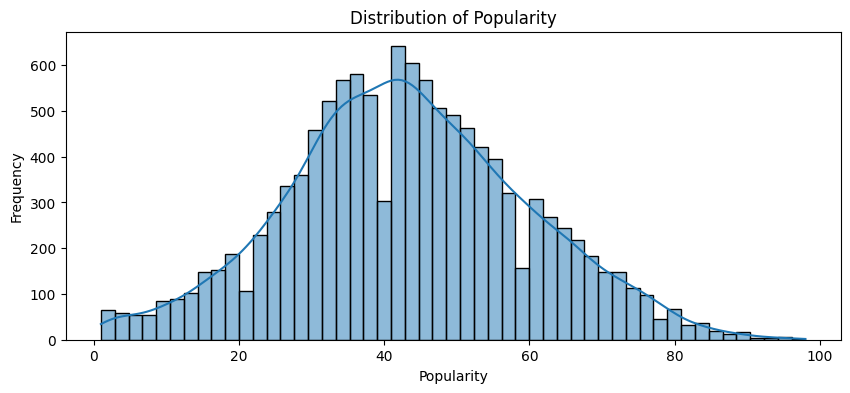

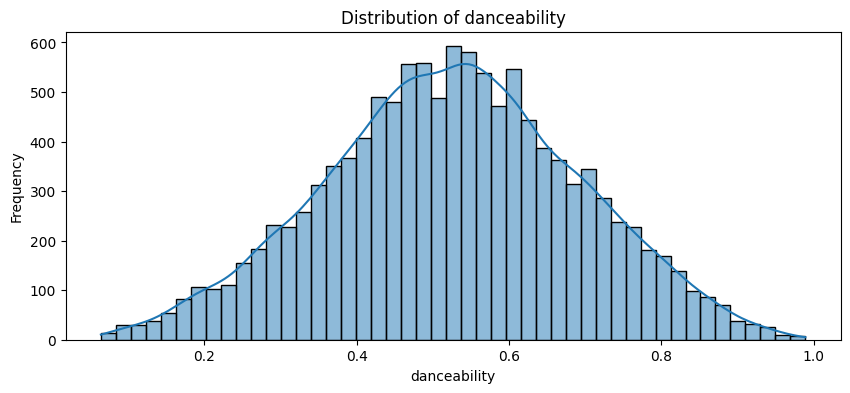

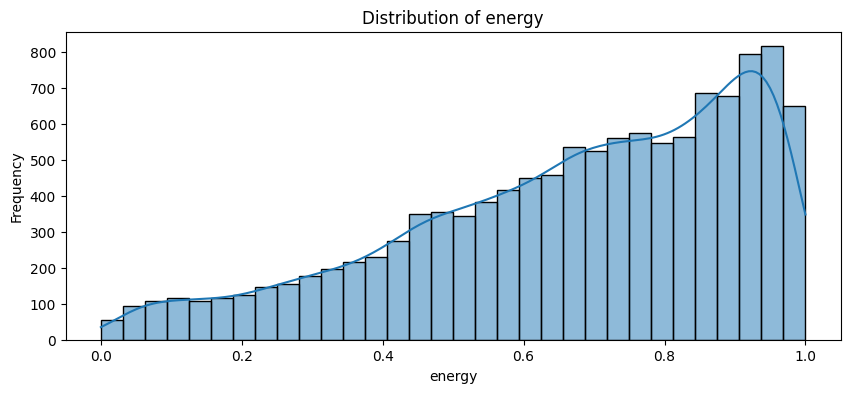

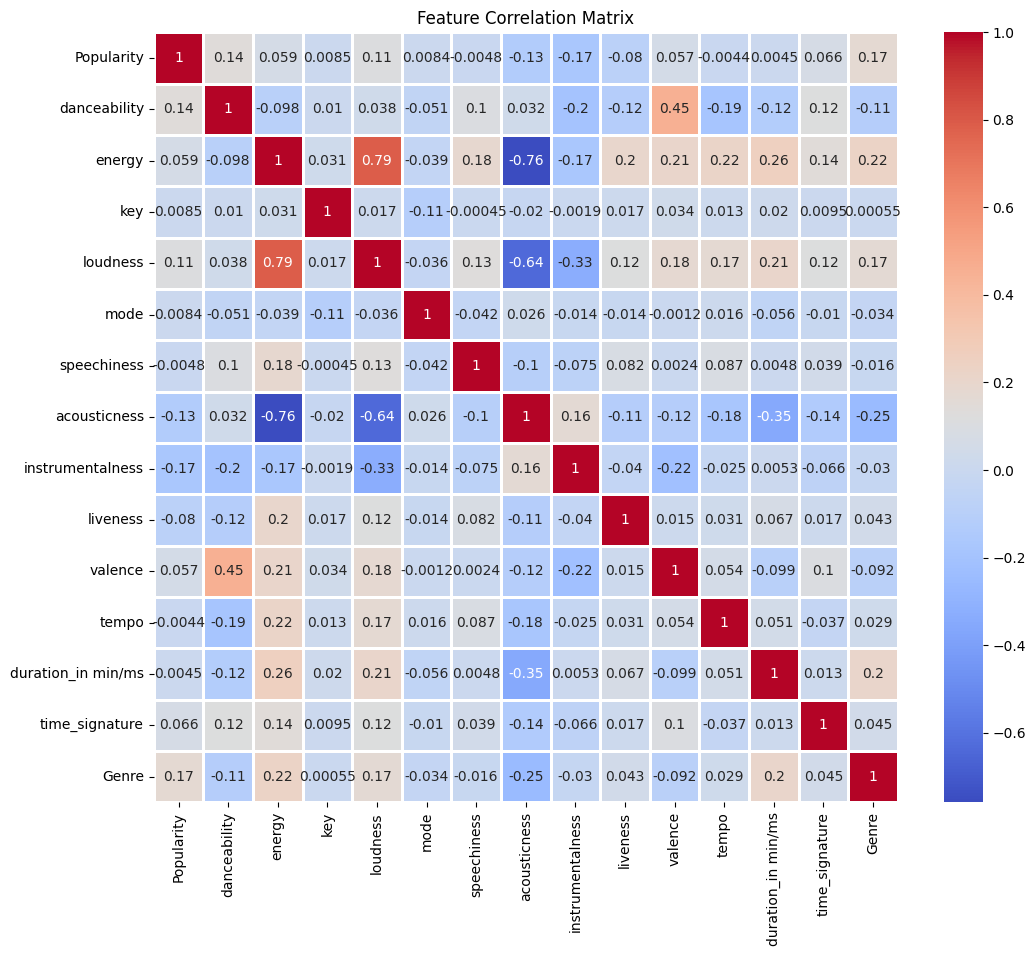

Model Evaluation:
Accuracy: 0.4845535336436733
Precision: 0.44563040586072256
Recall: 0.4845535336436733
F1 Score: 0.4554439965810485


In [6]:
# Widget for user input
user_input_widget = widgets.Textarea(
    value='',
    placeholder='Enter values separated by space: Popularity danceability energy key loudness mode speechiness acousticness instrumentalness liveness valence tempo duration_in min/ms time_signature',
    description='Attributes:',
    disabled=False,
    layout={'width': '400px', 'height': '100px'}
)
display(user_input_widget)

# Button to submit user input
submit_button = widgets.Button(
    description='Predict Genre',
    button_style='info',
    tooltip='Click to predict genre'
)
display(submit_button)


# Create an output widget to capture and display output
output_widget = widgets.Output()
display(output_widget)


def on_submit_button_clicked(b):
    """Handles button click event"""
    with output_widget:
        output_widget.clear_output()  # Clear the previous output
        # Extract user input
        user_input_raw = user_input_widget.value.split()
        user_input = validate_input(user_input_raw)

        if user_input is not None:
            prediction = make_prediction(model, scaler, user_input)
            print(f"Predicted genre: {prediction}")
        else:
            print("Invalid input. Please ensure your input matches the expected format and range.")


submit_button.on_click(on_submit_button_clicked)

# Load and preprocess the training data
train_filepath = 'train.csv'
df_train = load_and_preprocess_data(train_filepath)

# Visualize selected feature distributions and the correlation matrix
selected_features = ['Popularity', 'danceability', 'energy']
plot_feature_distributions(df_train, selected_features)
plot_correlation_matrix(df_train)

# Split the data for training and testing
X_train, X_test, y_train, y_test = split_data(df_train)

# Train the model
model, scaler = train_model(X_train, y_train)

# Evaluate the model's performance on the test set
accuracy, precision, recall, f1 = evaluate_model(model, scaler, X_test, y_test)
print(f"Model Evaluation:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")